Cite:
- LogMelExtractor:https://github.com/qiuqiangkong/dcase2019_task1
- GaborFilterbank:https://github.com/scikit-maad/scikit-maad/blob/production/maad/features/shape.py

In [1]:
import numpy as np
import librosa
from omegaconf import OmegaConf as OC
import matplotlib.pyplot as plt
import itertools as it 
from skimage import transform
from scipy import ndimage as ndi 

In [2]:
hparams = OC.load('hparameter.yaml')

In [3]:
class LogMelExtractor(object):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, fmax):
        '''Log mel feature extractor. 
        
        Args:
          sample_rate: int
          window_size: int
          hop_size: int
          mel_bins: int
          fmin: int, minimum frequency of mel filter banks
          fmax: int, maximum frequency of mel filter banks
        '''
        
        self.window_size = window_size
        self.hop_size = hop_size
        self.window_func = "hann"
        
        self.df = sample_rate/window_size
        self.window_size = window_size
        self.fmax = fmax
        
        self.melW = librosa.filters.mel(
            sr=sample_rate, 
            n_fft=window_size,
            n_mels=mel_bins, 
            fmin=fmin, 
            fmax=fmax)
        '''(n_fft // 2 + 1, mel_bins)'''

    def transform(self, audio):
        '''Extract feature of a singlechannel audio file. 
        
        Args:
          audio: (samples,)
          
        Returns:
          feature: (frames_num, freq_bins)
        '''
    
        window_size = self.window_size
        hop_size = self.hop_size
        window_func = self.window_func
        
        # Compute short-time Fourier transform
        stft_matrix = librosa.core.stft(
            y=audio, 
            n_fft=window_size, 
            hop_length=hop_size, 
            window=window_func, 
            center=True, 
            dtype=np.complex64, 
            pad_mode='reflect')
        '''(N, n_fft // 2 + 1)'''
    
        # Mel spectrogram
        #mel_spectrogram = np.dot(np.abs(stft_matrix) ** 2, self.melW)

        mel_spectrogram: np.ndarray = np.einsum("...ft,mf->...mt", np.abs(stft_matrix) ** 2, self.melW, optimize=True)
        
        # Log mel spectrogram
        logmel_spectrogram = librosa.core.power_to_db(
            mel_spectrogram, ref=1.0, amin=1e-10, 
            top_db=None)
        
        logmel_spectrogram = logmel_spectrogram.astype(np.float32)
        
        return logmel_spectrogram
    
    def plot_melFilterBank(self):
        filterbank = self.melW
        fig, ax = plt.subplots(figsize=(10, 5))
        for c in range(len(filterbank)):
            ax.plot(np.arange(0,self.window_size/2+1)*self.df,filterbank[c])
        plt.title('Mel filter bank')
        plt.xlabel('Frequency[Hz]')
        plt.ylabel('Amplitude')
        fig.tight_layout(pad=0, w_pad=0, h_pad=0)
        plt.show()

In [4]:
feature_extractor = LogMelExtractor(
    sample_rate=hparams.audio.sample_rate, 
    window_size=hparams.audio.window_size, 
    hop_size=hparams.audio.hop_size, 
    mel_bins=hparams.audio.mel_bins, 
    fmin=hparams.audio.fmin, 
    fmax=eval(hparams.audio.fmax))

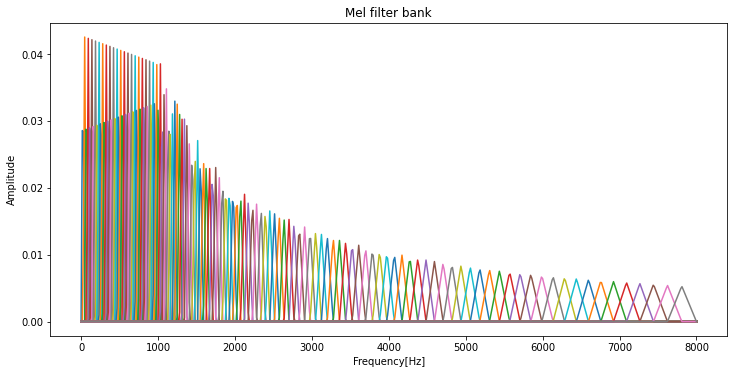

In [5]:
feature_extractor.plot_melFilterBank()

In [6]:
class GaborFilterbank(object):
    def __init__(self, frequency, ntheta, bandwidth=1, gamma=2, n_stds=3, offset=0, npyr=6):
        '''Gabor Filterbank.

        Args:
            frequency: 1d ndarray of scalars
                Spatial frequencies used to built the Gabor filters. Values should be in the range [0;1]

            ntheta: int
                Number of angular steps between 0° to 90°

            bandwidth: scalar, optional, default is 1
                Spatial-frequency bandwidth of the filter. This parameters affect the resolution of the filters.
                Lower bandwidth result in sharper in filters with more details.

            gamma: scalar, optional, default is 1
                Gaussian window that modulates the continuous sine.
                For ``gamma = 1``, the result is the same gaussian window in x and y direction (circle).
                For ``gamma <1``, the result is an increased elongation of the filter size in the y direction (elipsoid).
                For ``gamma >1``, the result is a reduction of the filter size in the y direction (elipsoid).

            n_stds : scalar, optional
                The linear size of the kernel is n_stds (3 by default) standard deviations

            offset : float, optional
                Phase offset of harmonic function in radians.
                
            npyr: int, optional
                Number of pyramids to compute. Default is 4.
        '''
        self.frequency = frequency
        self.ntheta = ntheta
        self.bandwidth = bandwidth
        self.gamma = gamma
        self.n_stds = n_stds
        self.offset = offset
        self.params, self.kernels = self.filter_bank_2d_nodc()
        
        self.npyr = npyr

    def filter_multires(self, Sxx, rescale=True,):
        '''Computes 2D wavelet coefficients at multiple scales using
           Gaussian pyramid transformation to downscale the input spectrogram.

        Args:
            Sxx: list of 2D arrays
                List of input spectrograms to filter


            rescale: boolean, optional
                Indicates if the reduced images should be rescaled. Default is True.

        Returns:
            Sxx_out: list of 2D arrays
                List of spectrograms filtered by each 2D kernel
        '''
        # Downscale image using gaussian pyramid
        if self.npyr < 2:
            print('Warning: npyr should be int and larger than 2 for multiresolution')
            im_pyr = tuple(transform.pyramid_gaussian(Sxx, downscale=2, max_layer=1, multichannel=False))
        else:
            im_pyr = tuple(transform.pyramid_gaussian(Sxx, downscale=2, max_layer=self.npyr - 1, multichannel=False))

        # filter 2d array at multiple resolutions using gabor kernels
        im_filt = []
        for im in im_pyr:  # for each pyramid
            for kernel, param in self.kernels:  # for each kernel
                im_filt.append(self._filter_mag(im, kernel))  # magnitude response of filter

        # Rescale image using gaussian pyramid
        if rescale:
            dims_raw = Sxx.shape
            Sxx_out = []
            for im in im_filt:
                ratio = np.array(dims_raw) / np.array(im.shape)
                if ratio[0] > 1:
                    im = transform.rescale(im, scale=ratio, mode='reflect', multichannel=False, anti_aliasing=True)
                else:
                    pass
                Sxx_out.append(im)
        else:
            pass

        return Sxx_out

    def _filter_mag(self, im, kernel):
        '''Normalizes the image and computes im and real part of filter response 
           using the complex kernel and the modulus operation.

        '''
        im = (im - im.mean()) / im.std()
        im_out = np.sqrt(ndi.convolve(im, np.real(kernel), mode='reflect') ** 2 +
                         ndi.convolve(im, np.imag(kernel), mode='reflect') ** 2)
        return im_out

    def filter_bank_2d_nodc(self, **kwargs):
        '''Build an ensemble of complex 2D Gabor filters with no DC offset.

        Args:
            display: bool
                Display a visualization of the filter bank. Default is False.

        Returns:
            params: 2d structured array
                 Parameters used to calculate 2D gabor kernels.

            kernels: 2d ndarray of complex values
                 Complex Gabor kernels
        '''
        theta = np.arange(self.ntheta)
        theta = theta / self.ntheta * np.pi
        params = [i for i in it.product(theta, self.frequency)]
        kernels = []
        for param in params:
            kernel = self._gabor_kernel_nodc(frequency=param[1], theta=param[0])
            kernels.append((kernel, param))
        return params, kernels

    def _gabor_kernel_nodc(self, frequency, theta=0):
        '''Computes complex 2D Gabor filter kernel with no DC offset.

        Returns:
            g_nodc : complex 2d array
                A complex gabor kernel with no DC offset
        '''
        # set gaussian parameters
        b = self.bandwidth
        sigma_pref = 1.0 / np.pi * np.sqrt(np.log(2) / 2.0) * (2.0 ** b + 1) / (2.0 ** b - 1)
        sigma_y = sigma_pref / frequency
        sigma_x = sigma_y / self.gamma
        # meshgrid
        x0 = np.ceil(max(np.abs(self.n_stds * sigma_x * np.cos(theta)),
                         np.abs(self.n_stds * sigma_y * np.sin(theta)), 1))
        y0 = np.ceil(max(np.abs(self.n_stds * sigma_y * np.cos(theta)),
                         np.abs(self.n_stds * sigma_x * np.sin(theta)), 1))
        y, x = np.mgrid[-y0:y0 + 1, -x0:x0 + 1]
        # rotation matrix
        rotx = x * np.cos(theta) + y * np.sin(theta)
        roty = -x * np.sin(theta) + y * np.cos(theta)
        # combine gambor and
        g = np.zeros(y.shape, dtype=np.complex)
        g[:] = np.exp(-0.5 * (rotx ** 2 / sigma_x ** 2 + roty ** 2 / sigma_y ** 2))
        g /= 2 * np.pi * sigma_x * sigma_y  # gaussian envelope
        oscil = np.exp(1j * (2 * np.pi * frequency * rotx + self.offset))  # harmonic / oscilatory function
        g_dc = g * oscil
        # remove dc component by subtracting the envelope weighted by K
        K = np.sum(g_dc) / np.sum(g)
        g_nodc = g_dc - K * g

        return g_nodc

    def plot_filter_bank(self):
        '''Display filter bank
        
        '''
        ntheta = self.ntheta
        nfreq = len(self.frequency)

        # get maximum size
        aux = list()
        for kernel in self.kernels:
            aux.append(max(kernel[0].shape))
        max_size = np.max(aux)

        # plot kernels
        fig, ax = plt.subplots(nfreq, ntheta)
        ax = ax.transpose()
        ax = ax.ravel()
        for idx, k in enumerate(self.kernels):
            kernel = np.real(k[0])
            ki, kj = kernel.shape
            ci, cj = int(max_size / 2 - ki / 2), int(max_size / 2 - kj / 2)
            canvas = np.zeros((max_size, max_size))
            canvas[ci:ci + ki, cj:cj + kj] +=  kernel
            ax[idx].imshow(canvas)
            ax[idx].axis('off')
        plt.tight_layout()

In [7]:
gbfb_extractor = GaborFilterbank(frequency=eval(hparams.gabor_high.frequency), 
                                  ntheta=hparams.gabor_high.ntheta,
                                  bandwidth=hparams.gabor_high.bandwidth, 
                                  gamma=hparams.gabor_high.gamma,
                                  npyr=hparams.gabor_high.npyr)

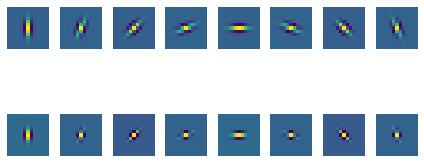

In [8]:
gbfb_extractor.plot_filter_bank()

In [9]:
from maad import sound
from maad.util import power2dB, plot2d

In [10]:
def plot2D(*param):
    fig, axs = plt.subplots(1, len(param), sharey=True, figsize=(10, 5))
    for col, s in enumerate(param):
        if np.ndim(param[0]) == 1:
            s = s[:16000*2]
            stft_matrix = librosa.core.stft(
                y=s, 
                n_fft=hparams.audio.window_size, 
                hop_length=hparams.audio.hop_size, 
                window="hann", 
                center=True, 
                dtype=np.complex64, 
                pad_mode='reflect')
            Sxx_db = np.abs(stft_matrix)**2
            Sxx_db = librosa.core.power_to_db(
                        Sxx_db, ref=1.0, amin=1e-10, 
                        top_db=None)
        else:
            Sxx_db = s
        ax = axs[col]
        Y = np.arange(0,np.shape(Sxx_db)[0],1)
        X = np.arange(0,np.shape(Sxx_db)[1]/16000,1/16000)
        ax.pcolormesh(X, Y, Sxx_db, shading='auto', cmap="coolwarm")

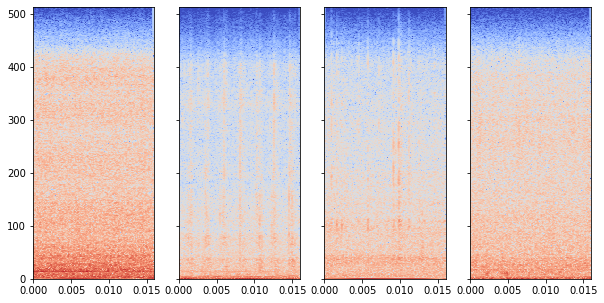

In [11]:
s1, fs = sound.load('../data/DeepShip/Tug/20171104-1/200959.wav')
s2, fs = sound.load('../data/DeepShip/Cargo/20171105a-3/3.wav')
s3, fs = sound.load('../data/DeepShip/Passengership/20160506d-3/3.wav')
s4, fs = sound.load('../data/DeepShip/Tanker/20160509-1/123109.wav')
#s, fs = sound.load('../data/p225_001.wav')
#s, fs = sound.load('D:/workplace/srdp/dataset/data/boliping/boliping.001.wav')
#s, fs = sound.load('D:/workplace/srdp/dataset/data/gandianchi/gandianchi.001.wav')
s1 = s1[:16000*2]
s2 = s2[:16000*2]
s3 = s3[:16000*2]
s4 = s4[:16000*2]
plot2D(s1,s2,s3,s4)

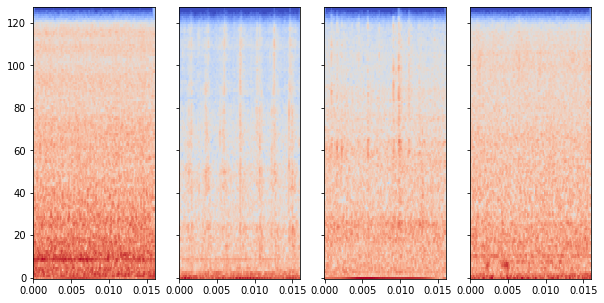

In [12]:
S1_dbmel = feature_extractor.transform(s1)
S2_dbmel = feature_extractor.transform(s2)
S3_dbmel = feature_extractor.transform(s3)
S4_dbmel = feature_extractor.transform(s4)

plot2D(S1_dbmel,S2_dbmel,S3_dbmel,S4_dbmel)

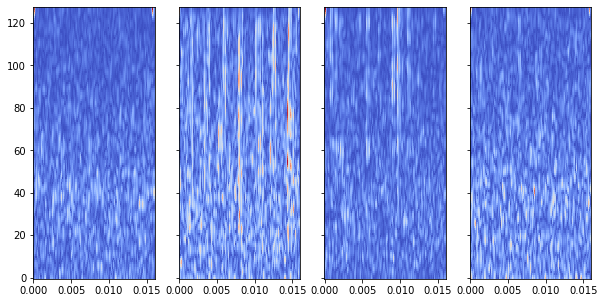

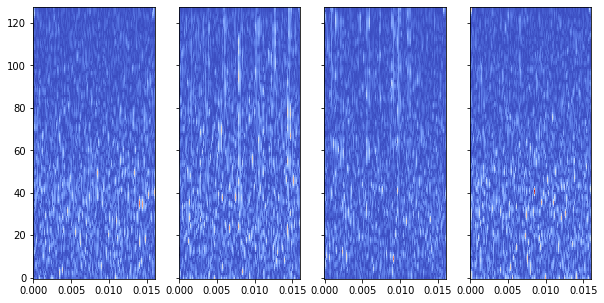

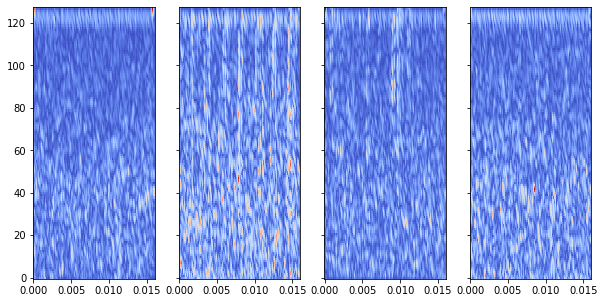

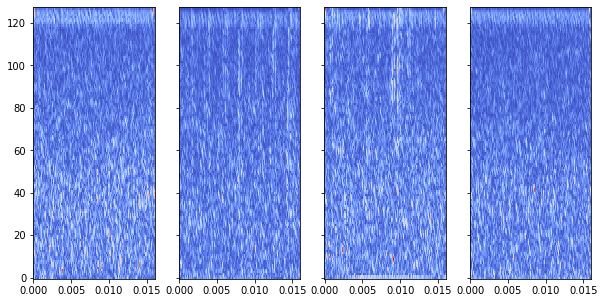

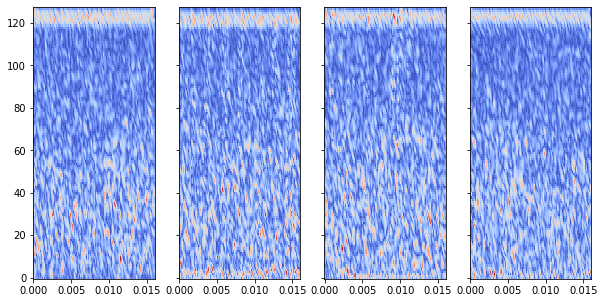

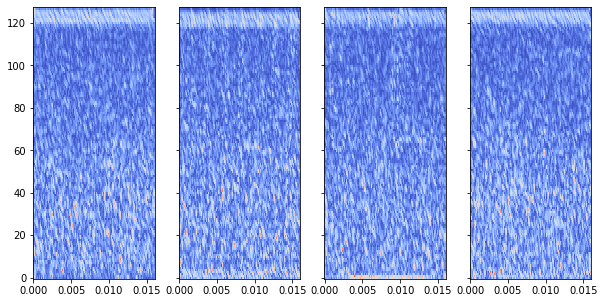

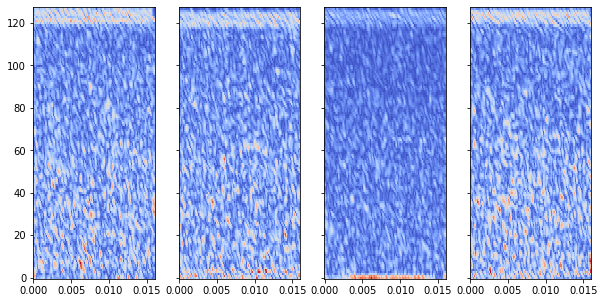

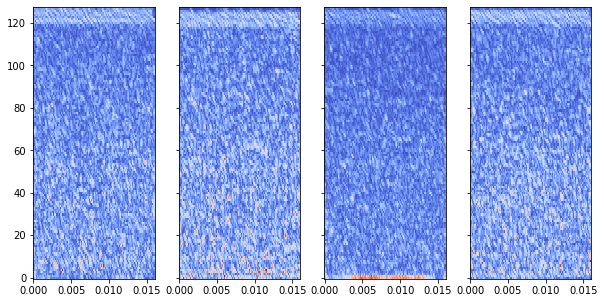

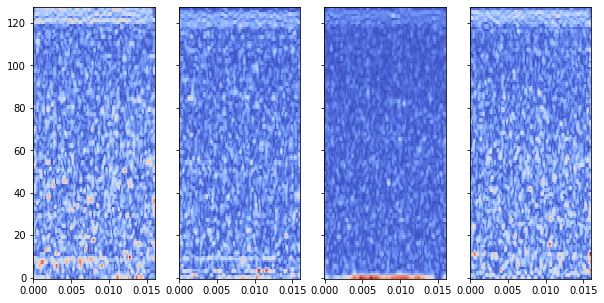

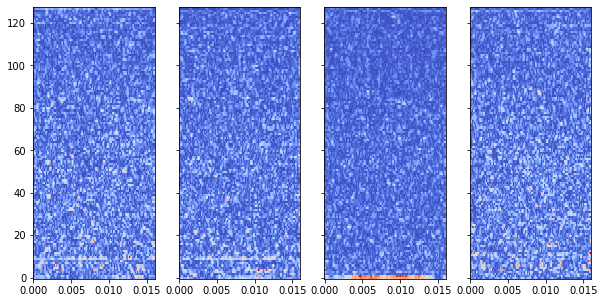

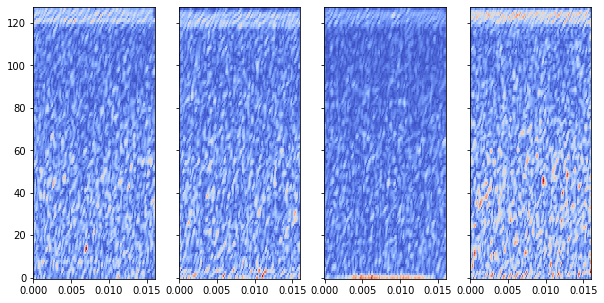

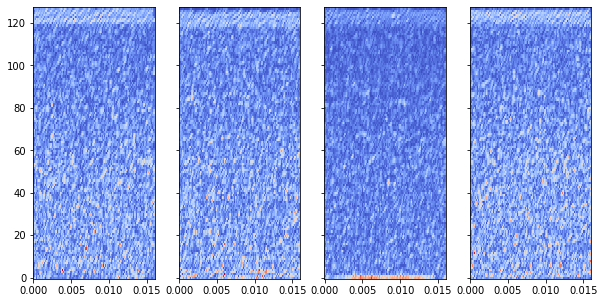

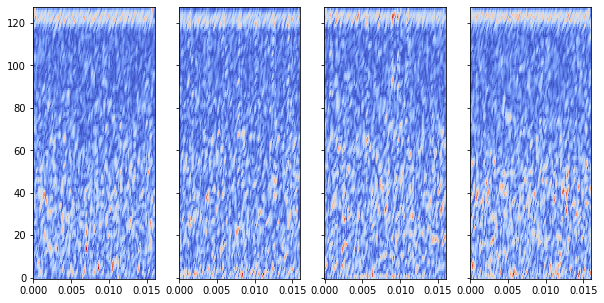

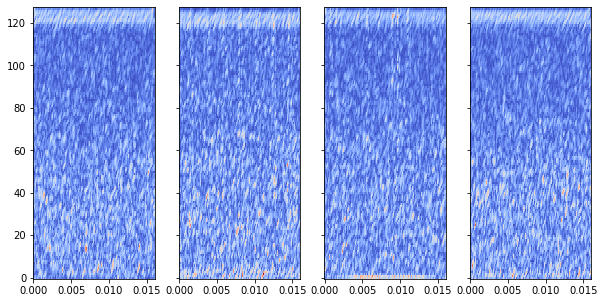

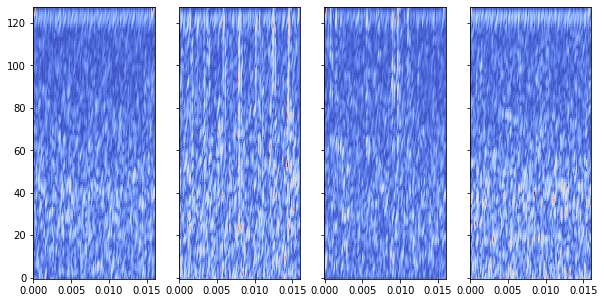

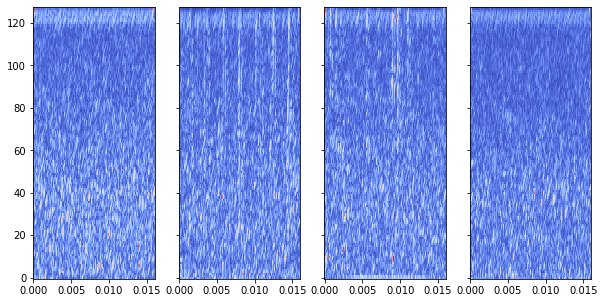

In [14]:
S1_gfb = gbfb_extractor.filter_multires(Sxx=S1_dbmel)
S2_gfb = gbfb_extractor.filter_multires(Sxx=S2_dbmel)
S3_gfb = gbfb_extractor.filter_multires(Sxx=S3_dbmel)
S4_gfb = gbfb_extractor.filter_multires(Sxx=S4_dbmel)
for i in range(16):
    plot2D(S1_gfb[i],S2_gfb[i],S3_gfb[i],S4_gfb[i])

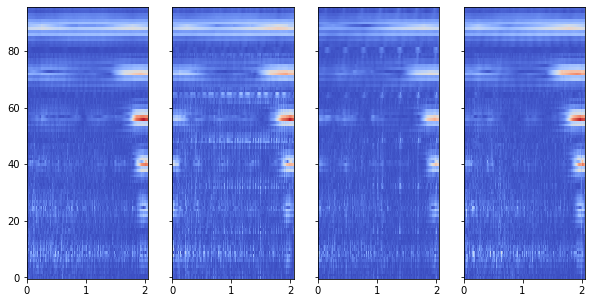

In [15]:
X1 = np.array(S1_gfb).reshape([len(S1_gfb), S1_dbmel.size]) # transpose()
X2 = np.array(S2_gfb).reshape([len(S2_gfb), S2_dbmel.size])
X3 = np.array(S3_gfb).reshape([len(S3_gfb), S3_dbmel.size])
X4 = np.array(S4_gfb).reshape([len(S4_gfb), S4_dbmel.size])

plot2D(X1,X2,X3,X4)